University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2023  
Luigi Acerbi  
Based on notebook by Antti Honkela 

# Lecture 11: Variational inference

Background reading: please see Chapter 12 of the "Course notes" available in Moodle.

All the exercises can be done using either Autograd or PyTorch.


## 0. A recap of variational inference

#### Variational inference on a general target density

In general, variational inference approximates a target (unnormalized) distribution $p_\text{target}(\theta)$ with a simpler distribution $q_\psi(\theta)$ parameterized by $\psi$. 
For example, if $q$ is a multivariate normal, $\psi$ could be the mean and covariance matrix of the distribution, $\psi = (\mu, \Sigma)$. Please note that while normal distributions are a common choice in variational inference, they are not the only one - you could choose $q$ to be *any* distribution of your choice.

For a given family of approximating distributions $q_\psi(\theta)$, variational inference chooses the best value of the parameters $\psi$ that make $q_\psi$ "as close as possible" to $p$ by maximizing the ELBO (evidence lower bound):  

$$
\text{ELBO}(\psi) = \mathbb{E}_{q_\psi(\theta)}\left[ \log p_\text{target}(\theta)\right] - \mathbb{E}_{q_\psi(\theta)}\left[\log q_\psi(\theta)\right]
$$

It can be shown that maximizing the ELBO is equivalent to minimizing $D_\text{KL}(q_\psi||p_\text{target})$, which is the Kullback-Leibler divergence between $q_\psi(\theta)$ and $p_\text{target}(\theta)$ (see lecture notes).

#### Variational inference to approximate a target posterior

While variational inference could be performed for any generic target density $p_\text{target}(\theta)$, the common scenario is that our target density is an unnormalized posterior distribution: 

$$p_\text{target}(\theta) = p(\mathcal{D} | \theta) p(\theta) \propto \frac{p(\mathcal{D} | \theta) p(\theta)}{p(\mathcal{D})}$$

where $p(\mathcal{D} | \theta) p(\theta) = p(\mathcal{D}, \theta)$ is the joint distribution. The (unknown) normalization constant is $p(\mathcal{D})$, also called the *model evidence* or *marginal likelihood*. In this typical usage-case scenario for variational inference, the ELBO reads

$$
\text{ELBO}(\psi) = \mathbb{E}_{q_\psi(\theta)}\left[ \log p(\mathcal{D}|\theta) p(\theta) \right] - \mathbb{E}_{q_\psi(\theta)}\left[\log q_\psi(\theta)\right]
$$

where we simply replaced $p_\text{target}$ with the unnormalized posterior.

#### Things to know

- The term $\mathbb{E}_{q_\psi(\theta)}\left[ \log p(\theta|\mathcal{D}) p(\theta) \right]$ in the ELBO is the expected log joint.
- The term $-\mathbb{E}_{q_\psi(\theta)}\left[ \log q_\psi(\theta) \right]$ is the *entropy* of $q_{\psi}(\theta)$, often written as $\mathcal{H}[q]$.
- Note that the ELBO is a function of $\psi$. The optimization finds the $\psi^*$ that maximizes the ELBO (in practice, the value $\psi^*$ that minimizes the negative ELBO).
- The ELBO is a lower bound to the log normalization constant of the target density, that is $\log p(\mathcal{D})$ when the target is the unnormalized posterior.
- For notational convenience, the dependence of $q_\psi(\theta)$ on $\psi$ is often omitted. Also $\psi$ is an arbitrary notation, you can also find other Greek letters to denote the variational parameters.

## 1. Examining the fit of a variational approximation

In this task we will use doubly stochastic variational inference to fit a fixed distribution in one dimension.

Our target distribution is $p(\theta) = \mathcal{N}(4, 2^2)$ and our approximation $q(\theta)$ is also normal with mean $m$ and standard deviation $c$. In the notation of Section 0 above, 

$$q_\psi(\theta) = \mathcal{N}\left(\theta; m, c^2 \right), \qquad \text{with} \;  \psi = (m, c).$$

We want to evaluate the negative Kullback-Leibler (KL) divergence 

$$\mathcal{L}(\psi) = -D_{\text{KL}}(q_\psi(\theta) \| p(\theta)) = \mathrm{E}_{q_\psi(\theta)}\left[\log p(\theta) - \log q_\psi(\theta)\right] = \mathrm{E}_{\phi(z)}\left[\log p(c \cdot z + m) - \log \phi(z) + \log |c|\right] $$

for arbitrary choices of $m \in \mathbb{R}$ and $c > 0$, and where $\phi$ is the standard normal with zero mean and unit variance. We do so by parametrizing the normally distributed random variable $\theta$ as $\theta = c \cdot z + m$ (last passage in the equation above; see also lecture notes). Note that the expectation in $\mathcal{L}$ is an integral.

1. Write a function to evaluate the expectation $\mathcal{L}$ by simple Monte Carlo, that is by sampling $z \sim \phi(z) = \mathcal{N}(z; 0, 1)$ and transforming $z$ back to $\theta$ as needed, for given values of $m$ and $c$.
2. Evaluate the KL divergence for a range of values for $m$ while keeping $c=2$ fixed and for $c$ while keeping $m=4$ fixed, and plot the resulting values as a function of $m$ and as a function of $c$ (one line graph for each). What do you expect to see?
3. Note that the expectation $\mathcal{L}(\psi)$ is simply an integral: 
$$
\mathcal{L}(\psi) = \mathrm{E}_{\phi(z)}[\log p(c \cdot z + m) - \log \phi(z) + \log |c|] = \int_{-\infty}^\infty \phi(z) \left[\log p(c \cdot z + m) - \log \phi(z) + \log |c|\right] dz
$$
   It is convenient to evalute $\mathcal{L}(\psi)$ via simple Monte Carlo, but if we wanted, we could compute the integral with any other know technique for evaluating integrals. Repeat point (2) using instead a numerical integration method to evaluate $\mathcal{L}(\psi)$ (e.g., from `scipy.integrate`) and compare your results. Why would we use simple Monte Carlo vs. a more precise numerical quadrature method?



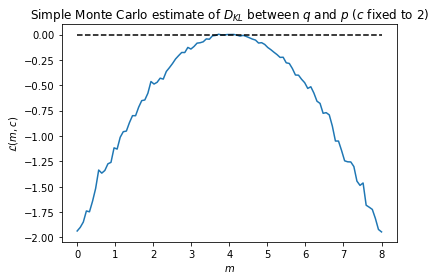

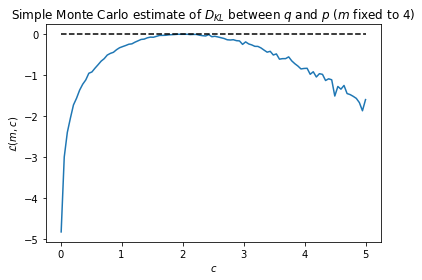

In [1]:
%matplotlib inline
import autograd.numpy as np
import autograd.numpy.random as npr
import matplotlib.pyplot as plt
from scipy import integrate

# 1

def lnormpdf(x, mu, sigma):
    """Log pdf of normal distribution with mean mu and standard deviation sigma."""
    return -0.5*np.log(2*np.pi*sigma**2) - 0.5*(x-mu)**2/sigma**2

def kl_mc(m, c, N=1000):
    """Estimate KL-divergence via simple Monte Carlo."""
    z = npr.normal(size=N)
    theta = c*z + m
    return np.mean(lnormpdf(theta, 4, 2) - lnormpdf(z, 0, 1) + np.log(np.abs(c)))

# 2

m = np.linspace(0, 8, 100)
y = np.array([kl_mc(mm, 2) for mm in m])
plt.plot(m, y)
plt.plot((0,8),(0,0),'k--')
plt.xlabel(r'$m$')
plt.ylabel(r'$\mathcal{L}(m,c)$')
plt.title(r'Simple Monte Carlo estimate of $D_{KL}$ between $q$ and $p$ ($c$ fixed to $2$)')
plt.show()

c = np.linspace(0.01, 5, 100)
y = np.array([kl_mc(4, cc) for cc in c])
plt.plot(c, y)
plt.plot((0.01,5),(0,0),'k--')
plt.xlabel(r'$c$')
plt.ylabel(r'$\mathcal{L}(m,c)$')
plt.title(r'Simple Monte Carlo estimate of $D_{KL}$ between $q$ and $p$ ($m$ fixed to $4$)')
plt.show()

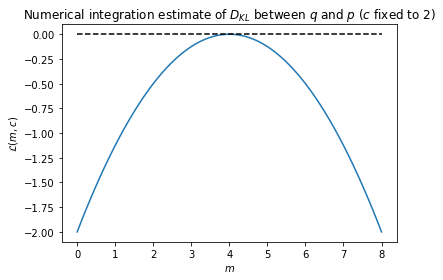

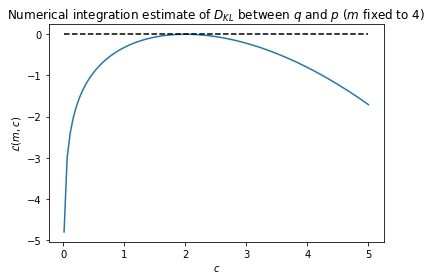

In [2]:
# 3

def kl_integral(m, c):
    """Compute KL-divergence via numerical integration."""
    zz = np.linspace(-10, 10, 10000)
    thetas = c*zz + m
    yy = np.exp(lnormpdf(zz,0,1)) * (lnormpdf(thetas, 4, 2) - lnormpdf(zz, 0, 1) + np.log(np.abs(c)))
    res = integrate.simpson(yy,zz)
    return res
    
m = np.linspace(0, 8, 100)
y = np.array([kl_integral(mm, 2) for mm in m])
plt.plot(m, y)
plt.plot((0,8),(0,0),'k--')
plt.xlabel(r'$m$')
plt.ylabel(r'$\mathcal{L}(m,c)$')
plt.title(r'Numerical integration estimate of $D_{KL}$ between $q$ and $p$ ($c$ fixed to $2$)')
plt.show()

c = np.linspace(0.01, 5, 100)
y = np.array([kl_integral(4, cc) for cc in c])
plt.plot(c, y)
plt.plot((0.01,5),(0,0),'k--')
plt.xlabel(r'$c$')
plt.ylabel(r'$\mathcal{L}(m,c)$')
plt.title(r'Numerical integration estimate of $D_{KL}$ between $q$ and $p$ ($m$ fixed to $4$)')
plt.show()

## 2. Fitting a variational approximation

Use stochastic gradient optimisation to maximise $\mathcal{L}$ using Algorithm 1 of Titsias and Lázaro-Gredilla (*doubly stochastic variational inference*, or DSVI):
``` {python}
    c[0] = c0
    m[0] = m0
    for i in range(iters):
        z = simulate_phi()
        theta = c[i] * z + m[i]
        g = gradient(theta)
        m[i+1] = m[i] + rho_t * g
        c[i+1] = c[i] + rho_t * (g * z + 1/c[i])
```

The function `gradient(theta)` here is assumed to return the gradient $\nabla \log p(\theta)$ (or $\nabla \log p(\theta, X)$ for posterior inference). The $\log q(z)$ term can be ignored as it does not depend on $m$ and $c$.

In order for the stochastic gradient algorithm to converge, the step size sequence $\rho_t$ should satisfy $\sum_{t=1}^{\infty} \rho_t = \infty$, $\sum_{t=1}^{\infty} \rho_t^2 < \infty$. A common choice for such a sequence is
$$ \rho_t = \frac{\rho_0}{t_0 + t} $$
which depends on parameters $\rho_0$ and $t_0$ that need to be tuned for each problem. You should try different values and plot the iterates $m$ and $c$ to see how they behave. Suitable $\rho_0$ can vary significantly for different problems, while something like $t_0 = 100$ might be a good starting point for many problems.

*Note*: There are more advanced algorithms that are generally superior to the basic stochastic gradient descent method outlined here. For example Adam (https://arxiv.org/abs/1412.6980) is a safe choice that seems to work well in practice for a broad range of problems.

m: 4.010114418381192, c: 2.0467395801052817


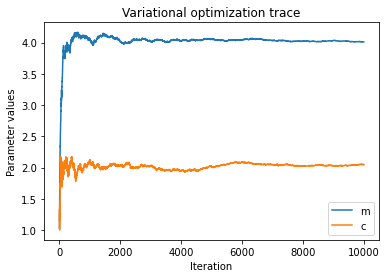

In [3]:
import autograd
import autograd.numpy as np
import autograd.numpy.random as npr

def dsvi(sample_z, m0, c0, gradient, rho_0, t0 = 100, niters = 10000):
    """Doubly stochastic variational inference in 1D."""
    m = m0
    c = c0
    m_history = np.zeros(niters)
    c_history = np.zeros(niters)
    for t in range(niters):
        z = sample_z()
        theta = c * z + m
        g = gradient(theta)
        m = m + rho_0 / (t0 + t) * g
        c = c + rho_0 / (t0 + t) * (g * z + 1/c)
        m_history[t] = m
        c_history[t] = c
    return m, c, m_history, c_history

def target(x):
    """Target log pdf."""
    return lnormpdf(x, 4, 2)

m, c, m_history, c_history = dsvi(npr.normal, 1.0, 1.0, autograd.grad(target), 10)

print('m: {}, c: {}'.format(m,c))
plt.plot(m_history,label='m')
plt.plot(c_history,label='c')
plt.xlabel(r'Iteration')
plt.ylabel(r'Parameter values')
plt.title('Variational optimization trace')
plt.legend()
plt.show()

## 3. Variational inference for normal mean estimation from data

Use doubly stochastic variational inference (DSVI) from the previous exercise to approximate the posterior for the mean $\mu$ of a normal model 
$$x_i \sim N(\mu, \sigma^2)$$ 
 with prior
$$ p(\mu) = \mathcal{N}(\mu_0, \sigma_0^2) $$
where $\sigma^2 = \sqrt{2}^2, \mu_0 = 3, \sigma_0^2 = \sqrt{10}^2$. We will use as dataset the provided toy data.

1. Parametrise $\mu$ as $\mu = c \cdot z + m$ as we did before and write a function to evaluate the ELBO
$$\mathcal{L}(c,m) = \mathrm{E}_{q(\mu)}[\log p(X, \mu) - \log q(\mu)] = \mathrm{E}_{\phi(z)}[\sum_{i=1}^n \log p(x_i | \mu) + \log p(\mu) - \log \phi(z) + \log |c|] $$
by sampling $z \sim \phi(z) = \mathcal{N}(z; 0, 1)$. Evaluate the ELBO for different values of $m$ and $c$. Can you find manually values of $(m, c)$ that are close to maximizing the ELBO?
2. Find the values $(m^*, c^*)$ that maximize the ELBO using DSVI. Evaluate the ELBO at the found solution and compare to the best value you found manually.
3.  Compare your result from (2) with the exact posterior $$ p(\mu | X, \sigma^2) = \mathcal{N}(\mu;\; m_\text{exact}, v_\text{exact}) $$
  where
$$ v_\text{exact} = \left( \frac{1}{\sigma_0^2} + \frac{n}{\sigma^2} \right)^{-1} \\
  m_\text{exact} = v_\text{exact} \cdot \left(\frac{n \bar{x}}{\sigma^2} + \frac{\mu_0}{\sigma_0^2} \right), $$
  where $\bar{x} = \frac{1}{n} \sum_{i=1}^n x_i$.
  
*Note*: Since nothing here is preventing $c$ from being negative, we can get negative results for it. Is this a problem in this specific case?

In [4]:
import autograd.numpy as np
import autograd.numpy.random as npr
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/toydata2.txt', sep='\t', header=None)
data = data.values
data = np.array(data[:,0])

print('Mean and standard deviation of the data: {}, {}'.format(np.mean(data), np.std(data)))

# 1

sigma0 = np.sqrt(10)
mu0 = 3
sigma = np.sqrt(2)
n = len(data)

def target2(mu):
    """Target log posterior (log likelihood + log prior)."""
    y = lnormpdf(mu, mu0, sigma0)
    for i in range(len(data)):
        y +=  lnormpdf(data[i], mu, sigma) 
    return y

def estimate_elbo(m,c,logp,ns=int(1e6)):
    """Estimate ELBO via Monte Carlo."""  # Could you use other methods here?
    # ELBO = E_q[log p] - E_q[log q]  (see first Eq. in Section 0 on top)
    x = c * npr.normal(size=ns) + m
    H = np.log(np.abs(c)*np.sqrt(2*np.pi*np.exp(1))) # H = -E_q[log q] is the entropy of q
    return np.mean(logp(x)) + H

def print_elbo(m,c):
    """Print ELBO for given variational parameters."""
    print('ELBO for (m={}, c={}): {}'.format(m,c,estimate_elbo(m,c,logp=target2)))

print_elbo(m=0,c=1)
print_elbo(m=4,c=1.44)
print_elbo(m=0,c=1.44)
print_elbo(m=4,c=0.5)
print_elbo(m=4,c=0.1)
print_elbo(m=4,c=0.05)
print_elbo(m=4,c=0.2)

Mean and standard deviation of the data: 3.9695260800000005, 1.4482060147882945
ELBO for (m=0, c=1): -300.18214308815965
ELBO for (m=4, c=1.44): -115.82248077053134
ELBO for (m=0, c=1.44): -313.2976200480803
ELBO for (m=4, c=0.5): -94.03494042010708
ELBO for (m=4, c=0.1): -92.63262065579649
ELBO for (m=4, c=0.05): -93.23189751868239
ELBO for (m=4, c=0.2): -92.31546036790414


variational posterior for mu: m: 3.965633067594809, c: 0.2048577032011365
ELBO for (m=3.965633067594809, c=0.2048577032011365): -92.30040012708375


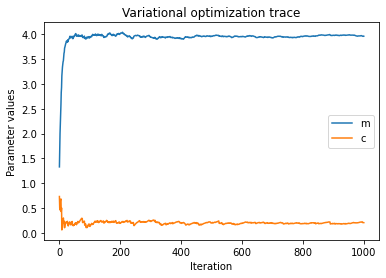

exact posterior for mu: m: 3.9656634262948205, c: 0.1996011960139498


In [5]:
# 2

m, c, m_history, c_history = dsvi(npr.normal, 1.0, 0.5, autograd.grad(target2), 0.5, niters=1000)
print('variational posterior for mu: m: {}, c: {}'.format(m,c))
print_elbo(m,c)

plt.plot(m_history,label='m')
plt.plot(c_history,label='c')
plt.xlabel(r'Iteration')
plt.ylabel(r'Parameter values')
plt.title('Variational optimization trace')
plt.legend()
plt.show()

# 3

v_exact = 1/(1/sigma0**2 + n/sigma**2)
m_exact = v_exact * (np.sum(data)/sigma**2 + mu0/sigma0**2)
print('exact posterior for mu: m: {}, c: {}'.format(m_exact,np.sqrt(v_exact)))

## 4. Variational approximation for a multimodal distribution

Use doubly stochastic variational inference to fit a variational approximation $q(\theta)$ to a target distribution that is a mixture of two normals:
$$ p(\theta) = \frac{1}{2} \mathcal{N}(\theta; -R, 1) + \frac{1}{2} \mathcal{N}(\theta; R, 1). $$
As before, we assume that $q(\theta)$ is a normal distribution.

1. Estimate the optimal variational approximation $q(\theta)$ for the above problem with $R = 1$. Plot the convergence curve ($m$ and $c$ values as a function of the number of iterations) to make sure you are converging efficiently. Also make a plot of the target $p(\theta)$ and the variational approximation $q(\theta)$ and compare the two.
2. Run the estimation for several values of $R$ in the range $[0,5]$. Plot the estimated $m^*$ and $c^*$ as a function of $R$. What do you observe?
3. Analyse the phase transition in the results. Plot the target distribution and the approximation for a few cases around the phase transition. Can you explain the transition?

*Hints*: 
- Remember to use stable numerical computation for $\log p(\theta)$ which we saw in Lecture 1.
- Note that generally the variational optimization problem is *not* convex, which means that you may have to restart the optimization from multiple points and check that you are getting the solution with the maximum ELBO.

In [6]:
import autograd
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.special as scs

def lnormpdf(x, mu, sigma):
    """Log pdf of normal distribution."""
    return -0.5*np.log(2*np.pi*sigma**2) - 0.5*(x-mu)**2/sigma**2

def target3(x, R):
    """Log pdf of target distribution."""
    zz = np.log(0.5) + np.array([lnormpdf(x, -R, 1), lnormpdf(x, R, 1)])
    return scs.logsumexp(np.log(0.5) + np.array([lnormpdf(x, -R, 1), lnormpdf(x, R, 1)]),0)

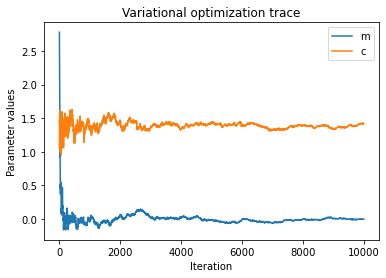

m: -0.00011851035322650095, c: 1.4187072495513504


In [7]:
# 1

R = 1
m, c, mv, cv = dsvi(npr.normal, 3.0, 1.0, autograd.grad(lambda x: target3(x, R)), 10)
plt.plot(mv,label='m')
plt.plot(cv,label='c')
plt.xlabel(r'Iteration')
plt.ylabel(r'Parameter values')
plt.title('Variational optimization trace')
plt.legend()
plt.show()

print('m: {}, c: {}'.format(m, c))

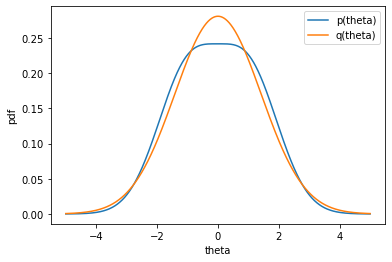

In [8]:
x = np.linspace(-5,5,1001)
plt.plot(x, np.exp(target3(x,R)),label='p(theta)')
plt.plot(x, np.exp(lnormpdf(x,m,c)),label='q(theta)')
plt.xlabel('theta')
plt.ylabel('pdf')
plt.legend()
plt.show()

In [9]:
# 2

npr.seed(43)
nruns = 3 # Multiple optimization runs

rvals = np.linspace(0.1, 5, 25)
mvals = np.zeros(len(rvals))
cvals = np.zeros(len(rvals))
k = np.zeros(nruns)

for i in range(len(rvals)):
    elbo_best = -np.inf
    for k in range(nruns):
        # We randomize the starting points a bit - could these points be chosen better?
        m0 = 3.0 + npr.normal()
        c0 = 1 + 0.2*npr.normal()
        logp = lambda x: target3(x, rvals[i])
        m_tmp, c_tmp, _, _ = dsvi(npr.normal, m0, c0, autograd.grad(logp), 10, niters=5000)
        elbo_tmp = estimate_elbo(m_tmp,c_tmp,logp,ns=int(1e6))
        if elbo_tmp > elbo_best:
            elbo_best = elbo_tmp
            m = m_tmp
            c = c_tmp        
    # Record the best result of the optimization runs
    mvals[i] = m
    cvals[i] = np.abs(c)
    print(r'R: {}, m: {}, c: {}, elbo: {}'.format(rvals[i], m, c, elbo_best))

R: 0.1, m: -0.014544862950698172, c: 1.0034010402895714, elbo: -0.000108000829862398
R: 0.3041666666666667, m: 0.02242880336820098, c: -1.0595927635635822, elbo: 0.0008079275020267396
R: 0.5083333333333334, m: 0.026473752241781983, c: 1.1332980344047363, elbo: -0.0011442271116501868
R: 0.7125, m: 0.033299676658018064, c: 1.203999707301981, elbo: -0.0020144905616727993
R: 0.9166666666666667, m: 0.0091917926883881, c: 1.3355698869039236, elbo: -0.006906354259155423
R: 1.1208333333333336, m: 0.03360340066278196, c: 1.456219562262022, elbo: -0.019003918078920545
R: 1.3250000000000002, m: 0.014075244438521956, c: 1.633405816174556, elbo: -0.04339580862382175
R: 1.529166666666667, m: 0.006230265194857219, c: 1.7107186852519207, elbo: -0.07991410202439297
R: 1.7333333333333336, m: 0.08932418446322085, c: 1.8933082144835587, elbo: -0.13326669902659383
R: 1.9375000000000002, m: 0.02955056814023788, c: 1.9878222221618373, elbo: -0.20115879560625283
R: 2.141666666666667, m: -0.04258230965699867, 

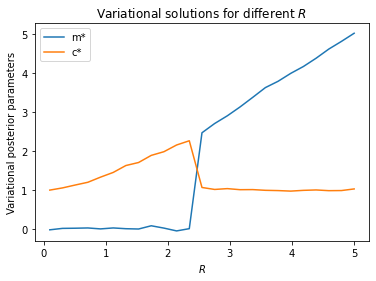

In [10]:
import matplotlib.pyplot as plt

plt.plot(rvals, mvals,label='m*')
plt.plot(rvals, cvals,label='c*')
plt.xlabel(r'$R$')
plt.ylabel(r'Variational posterior parameters')
plt.title(r'Variational solutions for different $R$')
plt.legend()
plt.show()

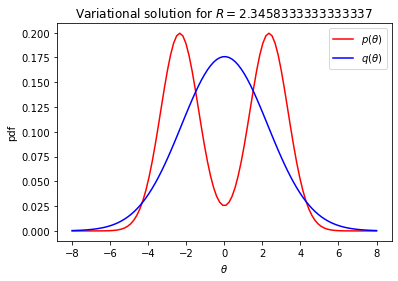

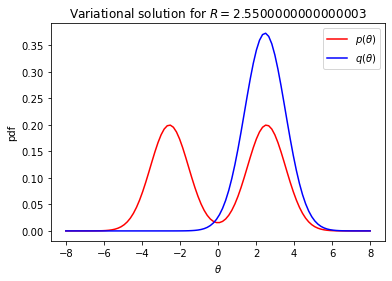

In [11]:
# 3
t = np.linspace(-8, 8, 100)
I_switch = np.where(np.abs(mvals) > 1.0)[0][0] # Find where the mean switches from ~0 to >> 1
I = [I_switch-1, I_switch]

for i in I:
    target_y = np.exp(np.array([target3(x, rvals[i]) for x in t]))
    approx_y = np.exp(lnormpdf(t, mvals[i], np.abs(cvals[i])))
    plt.plot(t, target_y, 'r', label=r'$p(\theta)$')    
    plt.plot(t, approx_y, 'b', label=r'$q(\theta)$')    
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'pdf')
    plt.title('Variational solution for $R = {}$'.format(rvals[i]))
    plt.legend()
    plt.show()